# 1. Import

In [1]:
# 1.1 Import required packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE, RFECV, SelectKBest, chi2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report, roc_auc_score, f1_score, roc_curve, precision_recall_curve, auc

# 1.2 Import data and split it into features and targets
data = pd.read_csv("processedData.csv")
X, y = data.loc[:, data.columns != 'Revenue'], data.loc[:, data.columns == 'Revenue']

In [2]:
# X['Avg_Administrative_Duration'] = X.apply(lambda row: row['Administrative_Duration'] / row['Administrative'] if row['Administrative'] != 0 else 0, axis=1)
# X['Avg_Informational_Duration'] = X.apply(lambda row: row['Informational_Duration'] / row['Informational'] if row['Informational'] != 0 else 0, axis=1)
# X['Avg_ProductRelated_Duration'] = X.apply(lambda row: row['ProductRelated_Duration'] / row['ProductRelated'] if row['ProductRelated'] != 0 else 0, axis=1)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=9)

cts_columns = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
X_train_cts = X_train[cts_columns]
X_train_dis = X_train.drop(columns=cts_columns)
X_test_cts = X_test[cts_columns]
X_test_dis = X_test.drop(columns=cts_columns)

# 2. Data Standardization

In [4]:
scaler = StandardScaler()
X_train_cts = pd.DataFrame(data=scaler.fit_transform(X_train_cts), columns=cts_columns)
X_train_dis.reset_index(inplace=True, drop=True)
X_train = pd.concat([X_train_cts, X_train_dis], axis=1)

X_test_cts = pd.DataFrame(data=scaler.transform(X_test_cts), columns=cts_columns)
X_test_dis.reset_index(inplace=True, drop=True)
X_test = pd.concat([X_test_cts, X_test_dis], axis=1)

# 3. Feature Engineering

<Axes: ylabel='Feature'>

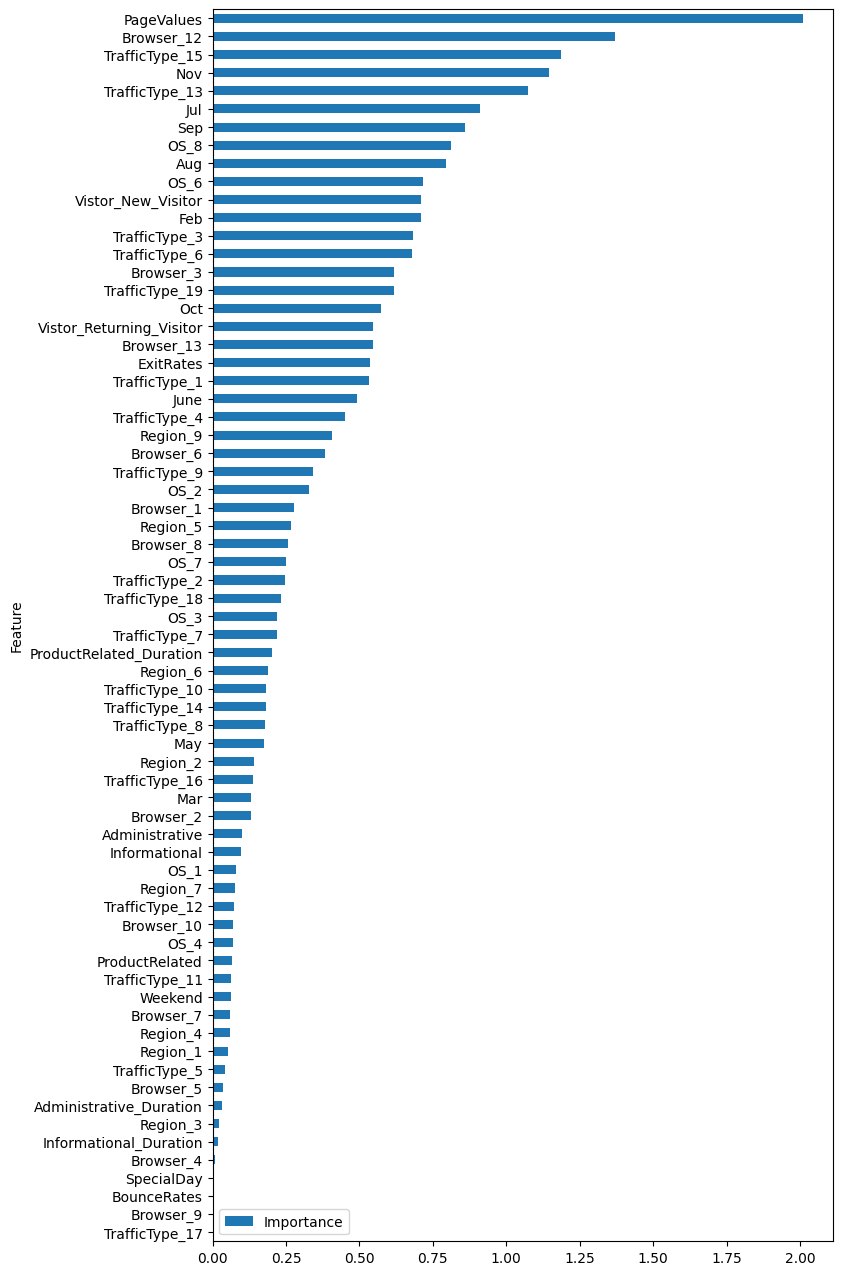

In [5]:
# Investigate Feature Importance
model = LogisticRegression(class_weight='balanced', solver='newton-cholesky', max_iter=1500)
model.fit(X_train, y_train['Revenue'])

coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(8, 16))

In [6]:
# Performed VIF to check multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# Calculate VIF for each feature
vif_data["VIF"] = pd.DataFrame([variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))])

print(vif_data[vif_data['feature'].isin(cts_columns)])

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


                   feature       VIF
0           Administrative  2.127673
1  Administrative_Duration  1.785255
2            Informational  2.137867
3   Informational_Duration  1.980114
4           ProductRelated  3.955946
5  ProductRelated_Duration  3.631359
6              BounceRates  6.927727
7                ExitRates  7.883394
8               PageValues  1.080465
9               SpecialDay  1.334120


By correlation matrix in preprocessing, BounceRates and ExitRates has high correlation (0.91). The VIF scores show both of them have high relation with other variables too. Since the feature importance of ExitRates is higher than that of BounceRates, we would drop BounceRates and test again

In [7]:
X = X.drop(columns=['BounceRates'])
X_train = X_train.drop(columns=['BounceRates'])
X_test = X_test.drop(columns=['BounceRates'])

In [8]:
# Performed VIF to check multicollinearity again
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# Calculate VIF for each feature
vif_data["VIF"] = pd.DataFrame([variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))])

print(vif_data[vif_data['feature'].isin(cts_columns)])

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


                   feature       VIF
0           Administrative  2.120250
1  Administrative_Duration  1.784785
2            Informational  2.137635
3   Informational_Duration  1.979841
4           ProductRelated  3.896941
5  ProductRelated_Duration  3.629722
6                ExitRates  1.359388
7               PageValues  1.071387
8               SpecialDay  1.329625


<Axes: >

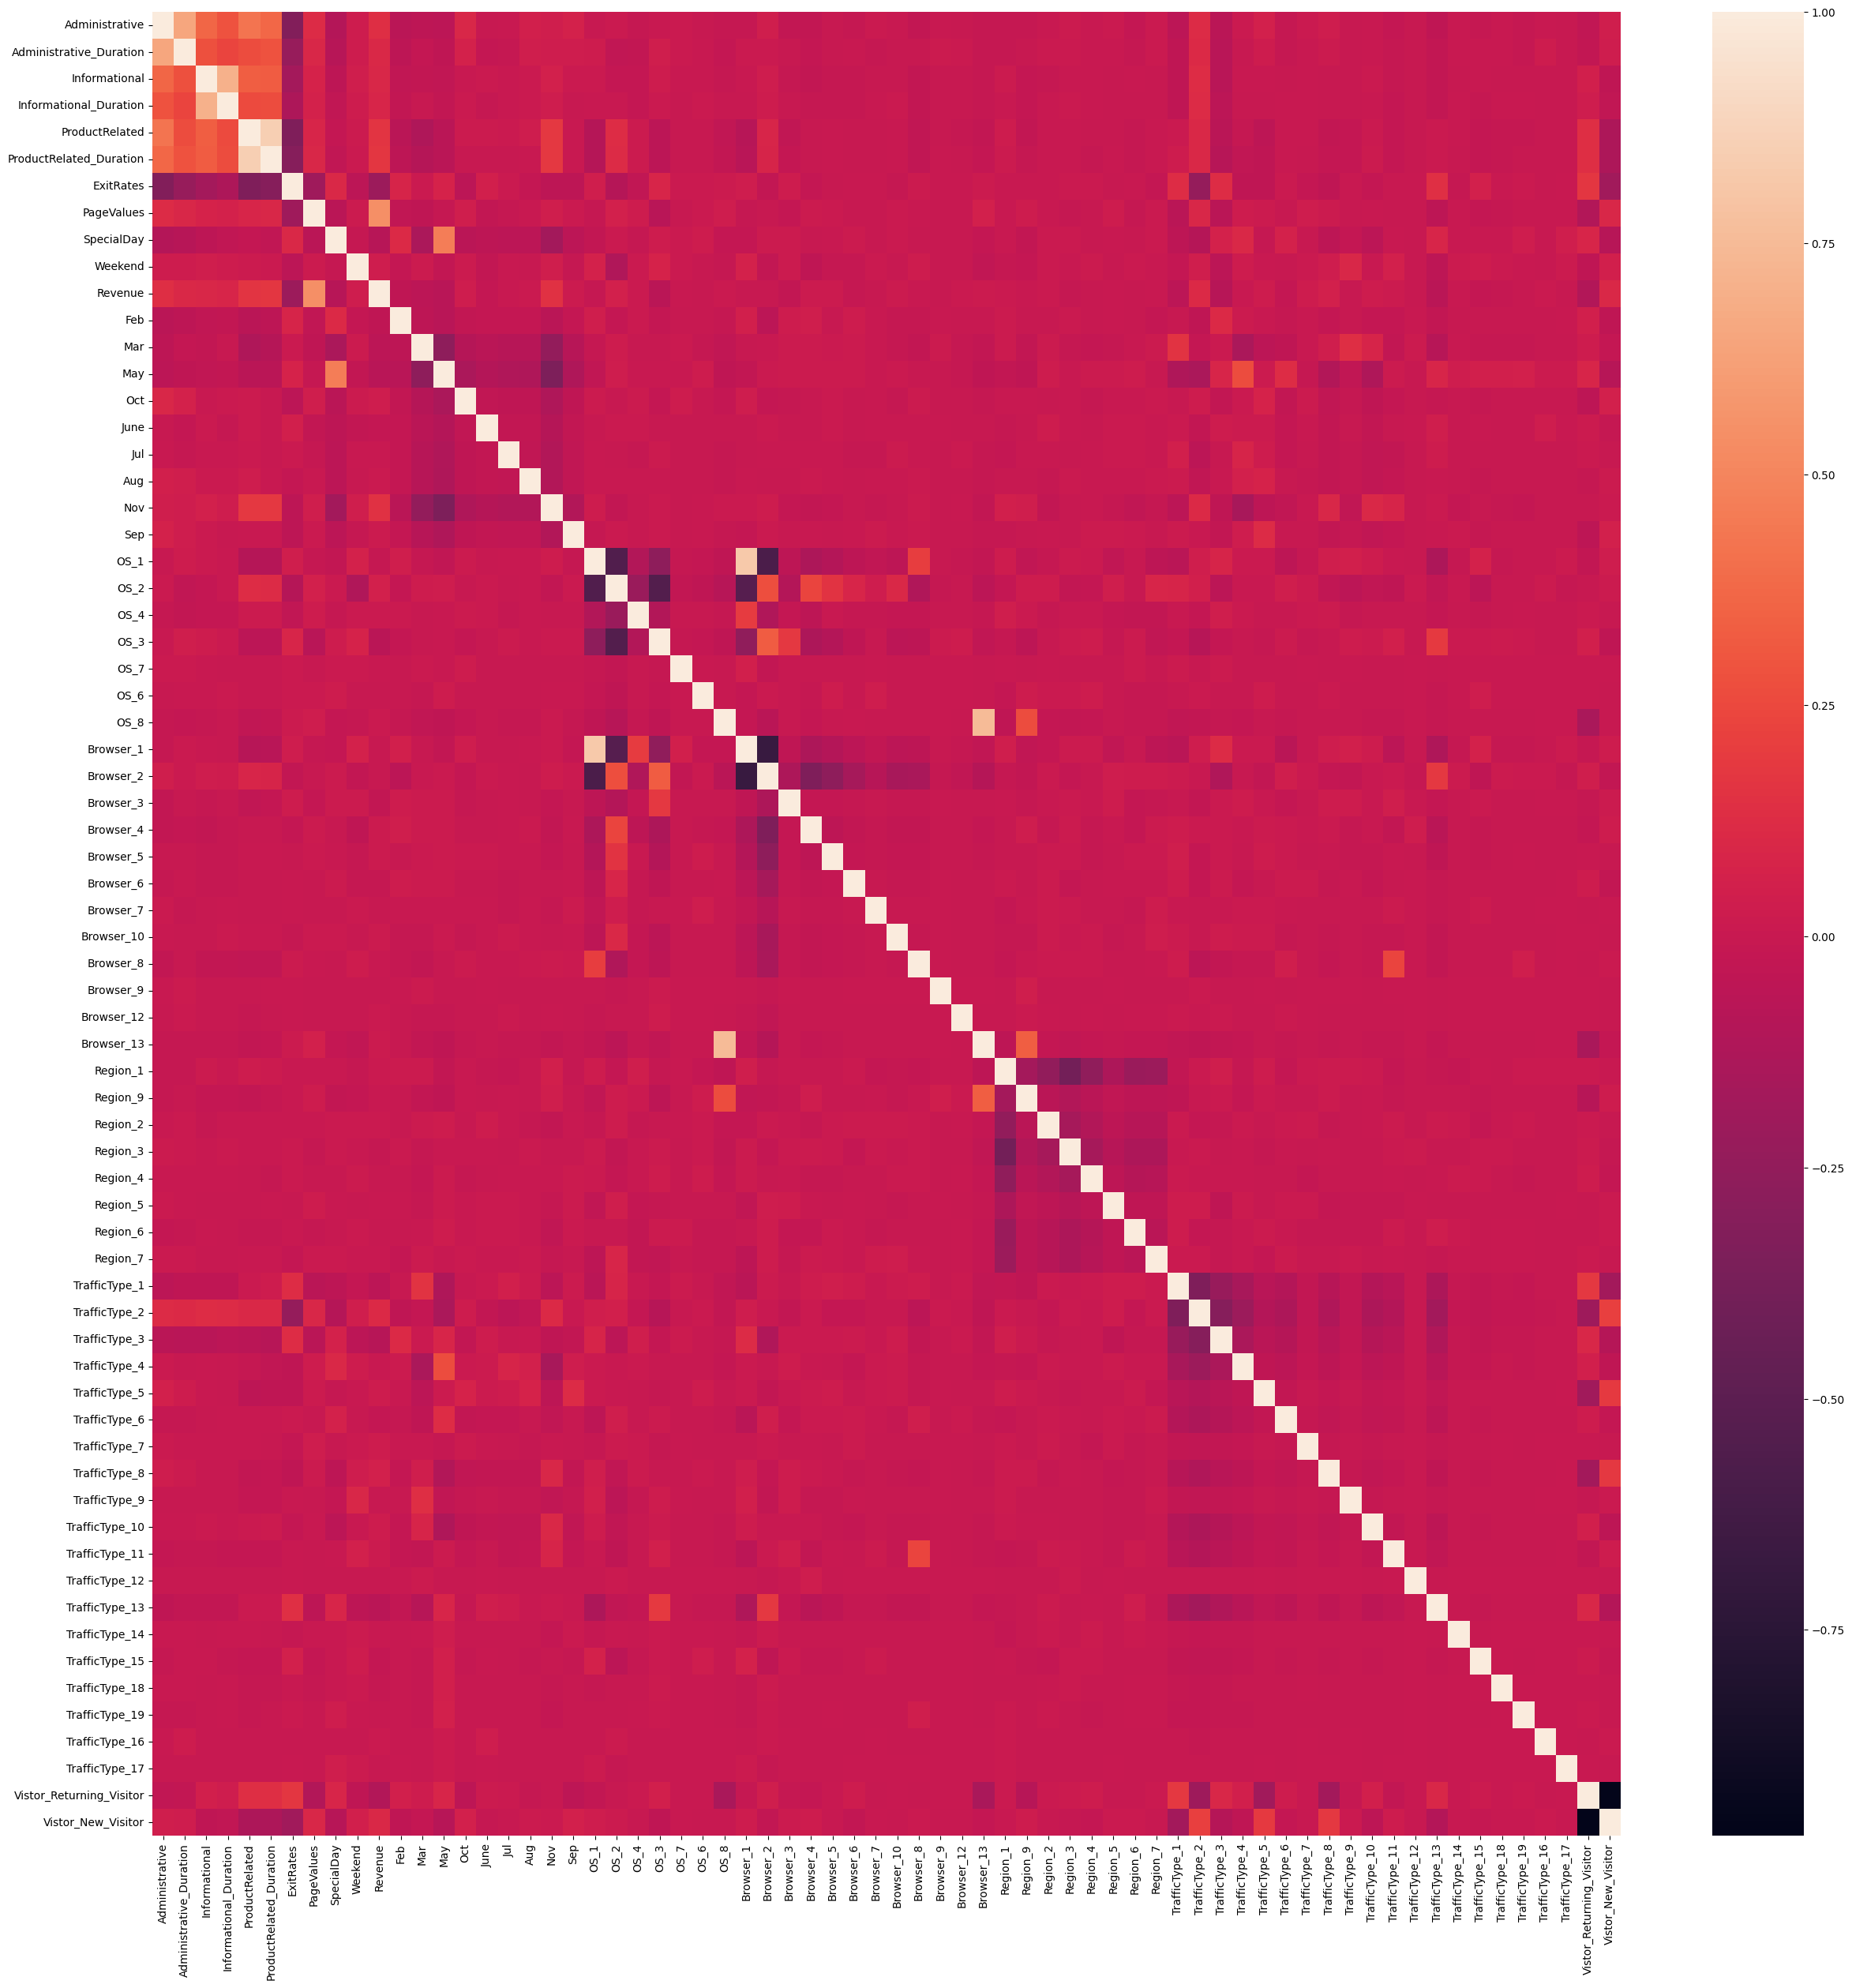

In [9]:
# Check Correlation Matrix again
data = data.drop(columns=['BounceRates'])
plt.subplots(1, 1, figsize=(30, 30))
data_correlation = data.corr()
sns.heatmap(data=data_correlation)#, annot=True, cmap='coolwarm', fmt=".2f")

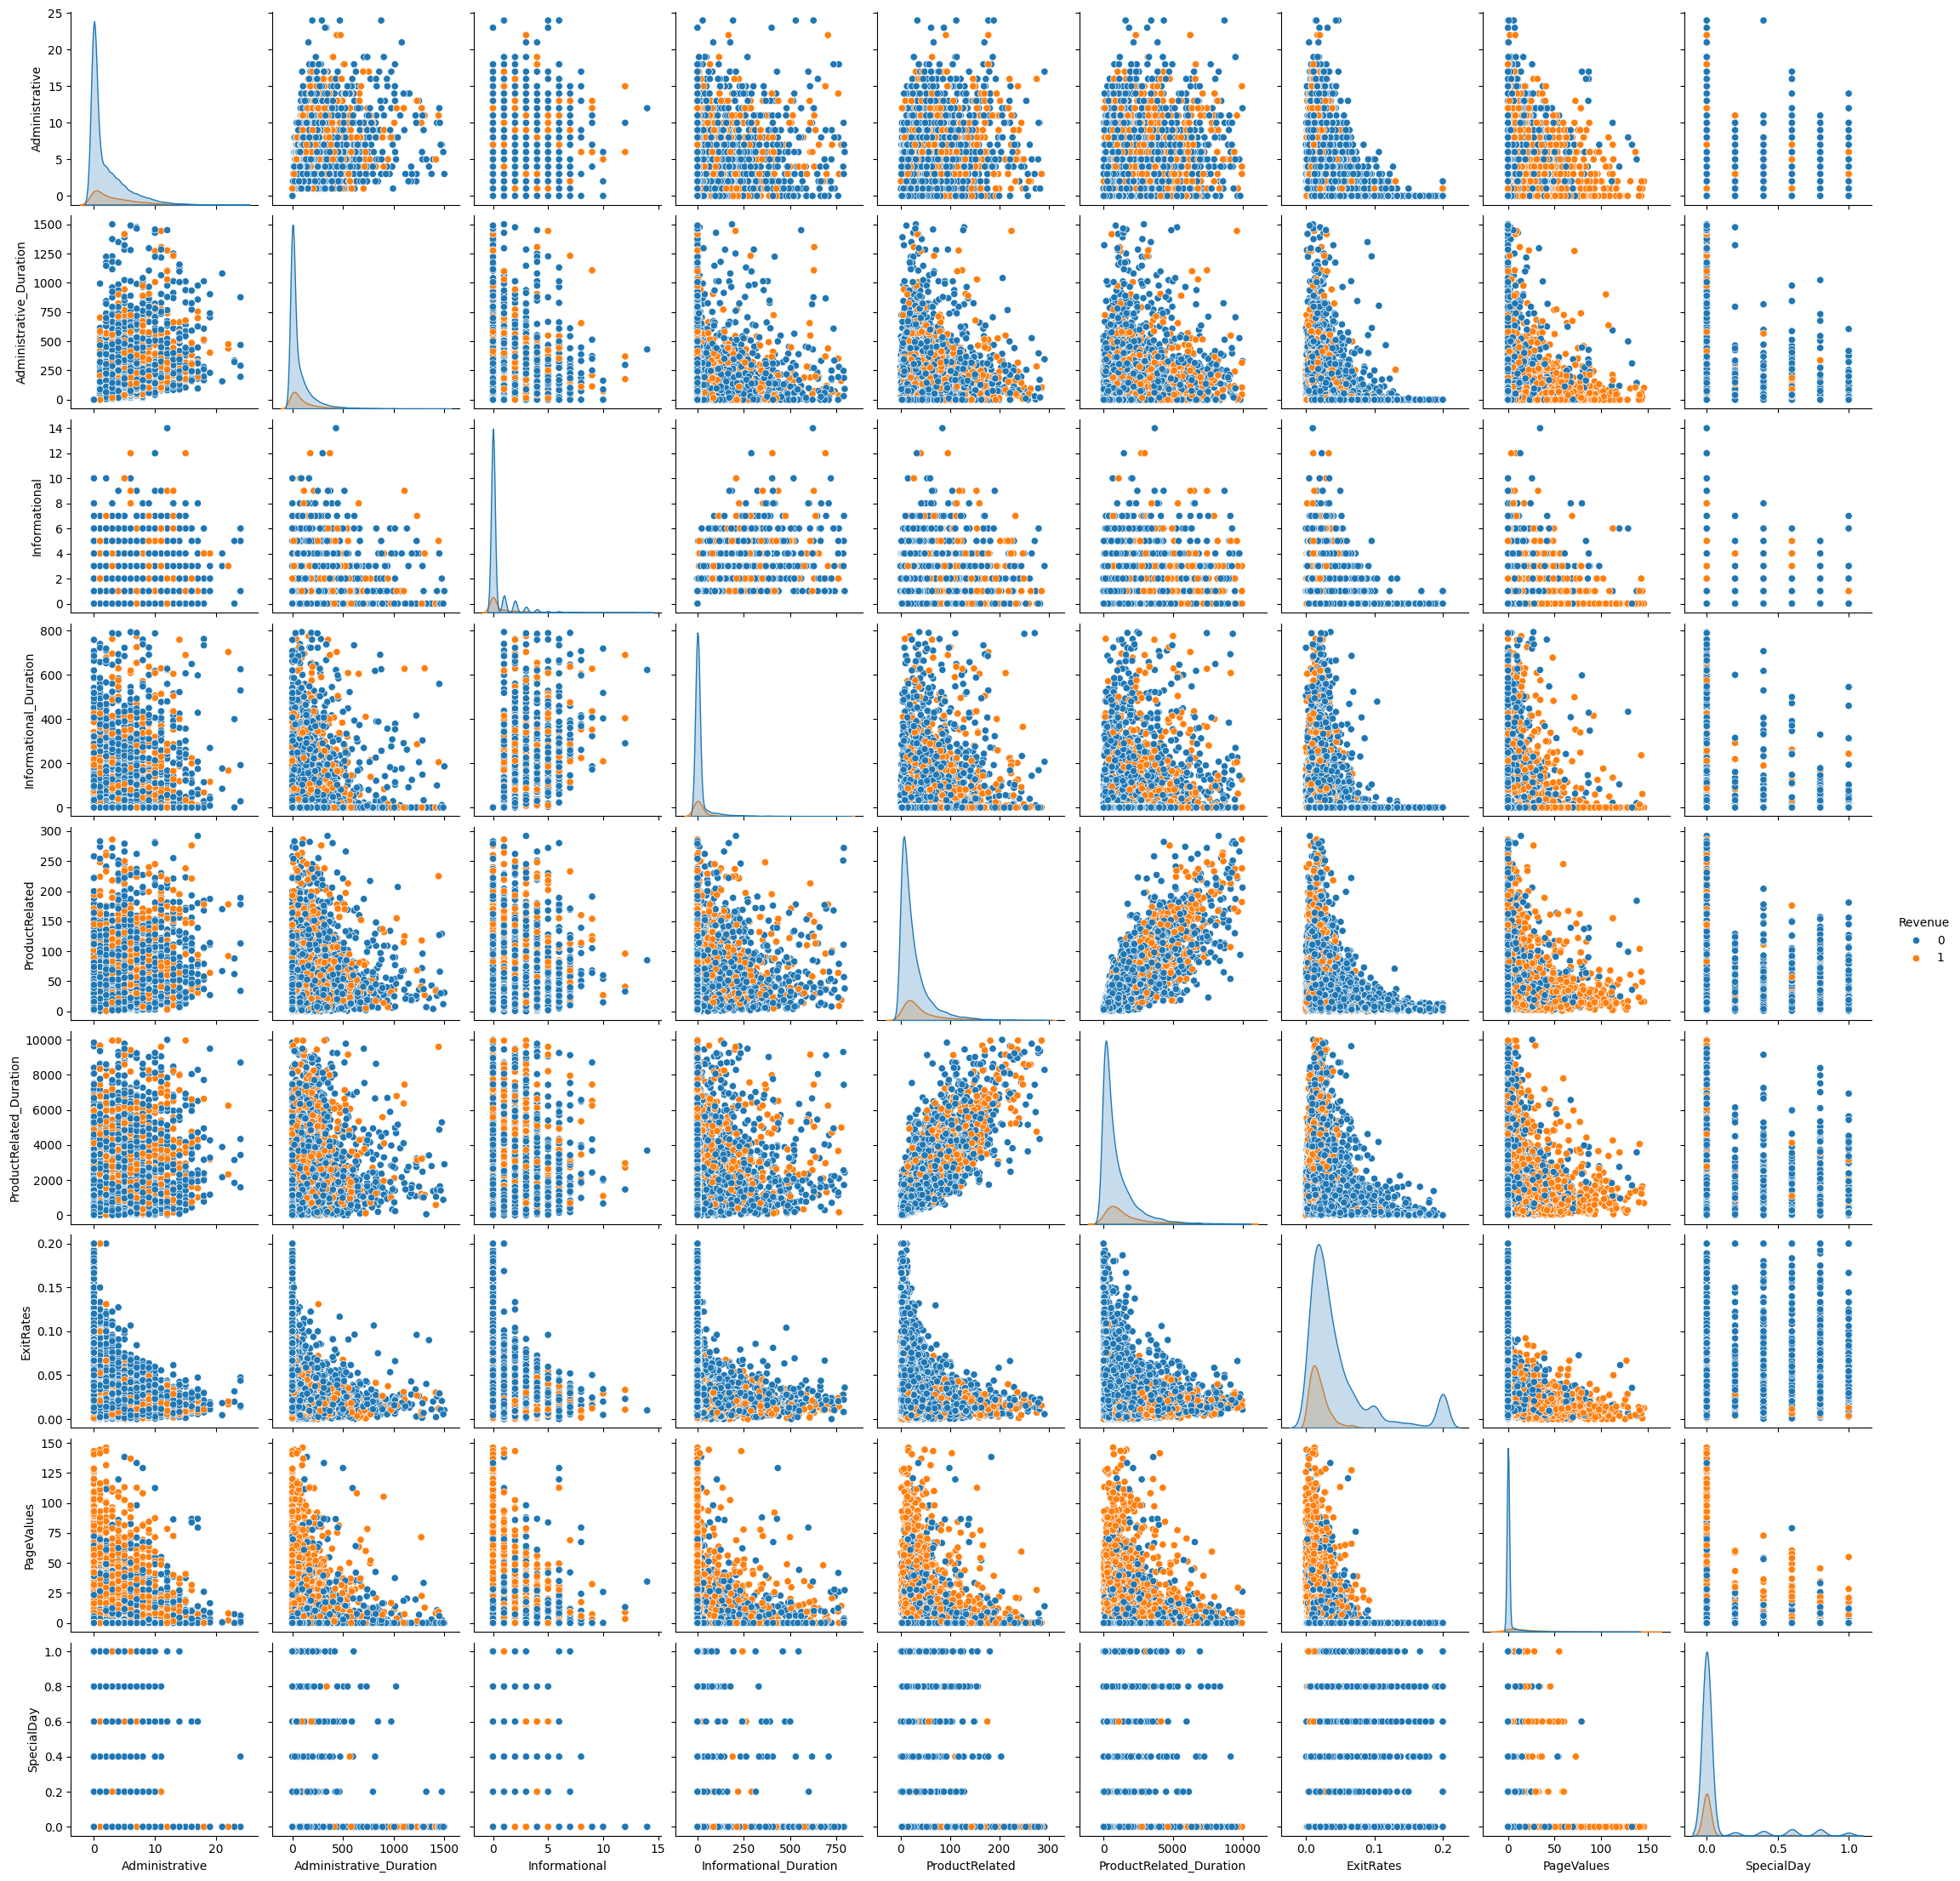

In [12]:
# Check Correlation between continuous variables
sns.pairplot(data=data[['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'ExitRates', 'PageValues', 'SpecialDay', 'Revenue']], hue='Revenue')

# 4. Feature Selection + Model Construction
We would like use the following methods for feature selection and test which model to use
1. Select features by RFECV (Recursive feature elimination with cross-validation)

In [13]:
# save_X_train = X_train.copy()
# save_y_train = y_train.copy()

Training set accuracy 0.8950687480616148
Testing set accuracy 0.9003720545680033
Balanced training set accuracy 0.7930258353786255
Balanced testing set accuracy 0.9003720545680033


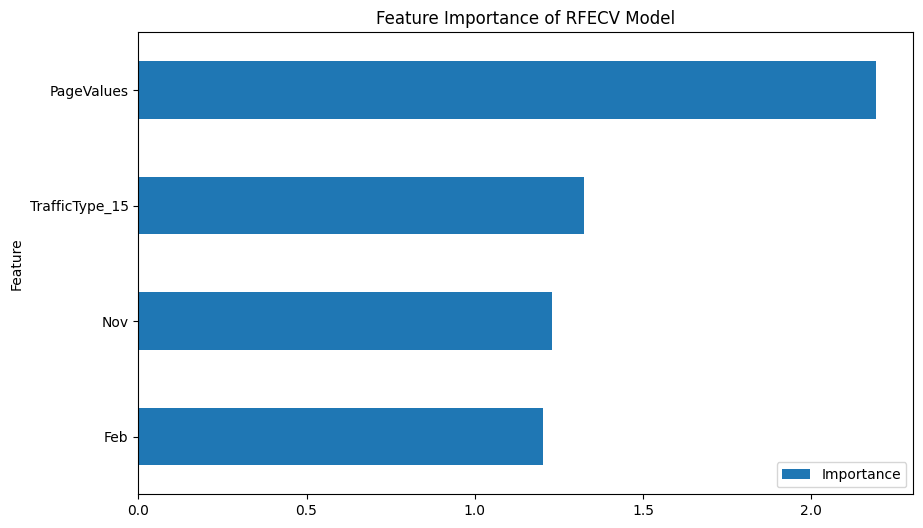

In [14]:
# RFECV: use Recursive feature elimination with cross-validation to select features.
# class_weight='balanced', solver='newton-cholesky'
estimator = LogisticRegression(class_weight='balanced', solver='newton-cholesky', max_iter=1500)
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=9)
selector = RFECV(estimator, step=1, cv=cv)
selector = selector.fit(X_train, y_train['Revenue'])

RFECV_model = LogisticRegression(class_weight='balanced', solver='newton-cholesky')

RFECV_model.fit(X_train[X_train.columns[selector.get_support()]], y_train['Revenue'])

# Print feature importances of selected features
coefficients = RFECV_model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns[selector.get_support()], 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), title='Feature Importance of RFECV Model')

# Perform Prediction and print accuracy
y_train_pred = RFECV_model.predict(X_train[X_train.columns[selector.get_support()]])
y_test_pred = RFECV_model.predict(X_test[X_train.columns[selector.get_support()]])


print("Training set accuracy", accuracy_score(y_train_pred, y_train))
print("Testing set accuracy", accuracy_score(y_test_pred, y_test))


print("Balanced training set accuracy", balanced_accuracy_score(y_train_pred, y_train))
print("Balanced testing set accuracy", accuracy_score(y_test_pred, y_test))

For training data: 
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      8215
           1       0.64      0.68      0.66      1458

    accuracy                           0.90      9673
   macro avg       0.79      0.81      0.80      9673
weighted avg       0.90      0.90      0.90      9673



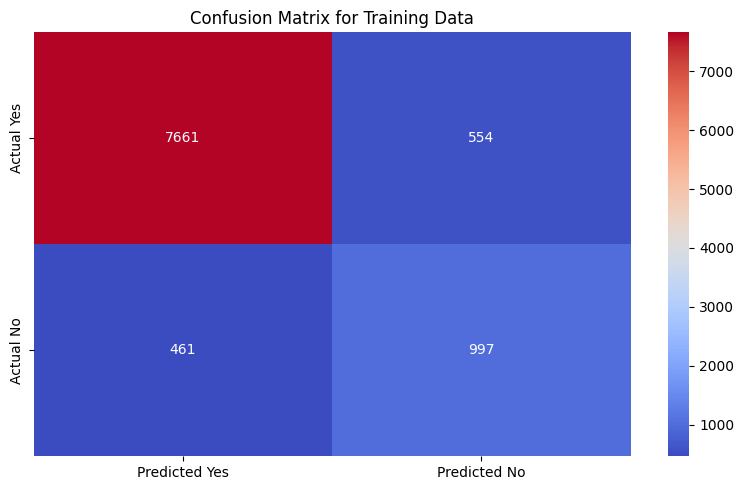

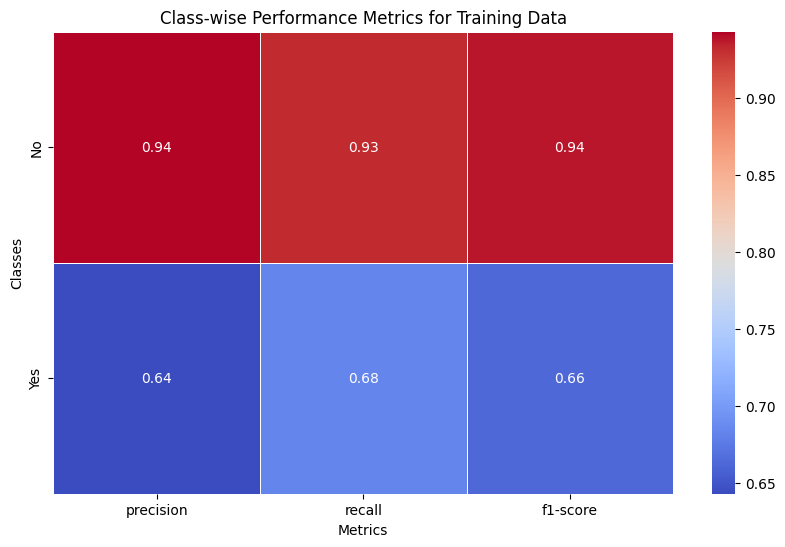

In [15]:
# Visualize the output for training set

# Classification Report
training_classification_report=classification_report(y_train, y_train_pred)
print("For training data: ")
print(training_classification_report)

# Confusion matrix with seaborn Heatmap
training_conf_matrix=confusion_matrix(y_train, y_train_pred)
# Seaborn Heatmap
plt.figure(figsize=(8,5))
sns.heatmap(training_conf_matrix, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted Yes', 'Predicted No'], yticklabels=['Actual Yes', 'Actual No'])
plt.title('Confusion Matrix for Training Data')
plt.tight_layout()
plt.savefig("training_confusion_matrix.png")

# Visualize classification report better: Class-wise Performance Metrics
training_classification_report_2 = classification_report(y_train, y_train_pred, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
class_metrics = {metric: [training_classification_report_2[class_name][metric] for class_name in ['0','1']] for metric in metrics}

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data=pd.DataFrame(class_metrics, index=['No','Yes']), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Class-wise Performance Metrics for Training Data')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.savefig("performance_metrics.png")
plt.show()



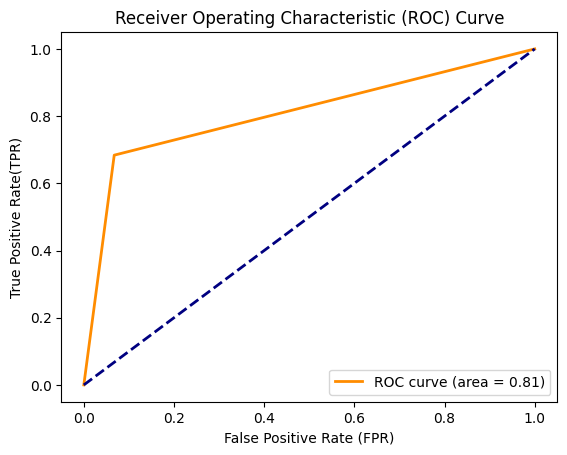

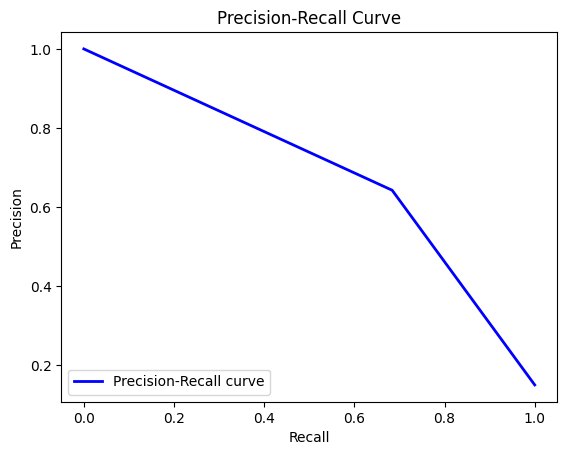

In [16]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_train, y_train_pred)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig("precision_recall_curve.png")
plt.show()

For testing data: 
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2055
           1       0.65      0.71      0.68       364

    accuracy                           0.90      2419
   macro avg       0.80      0.82      0.81      2419
weighted avg       0.90      0.90      0.90      2419



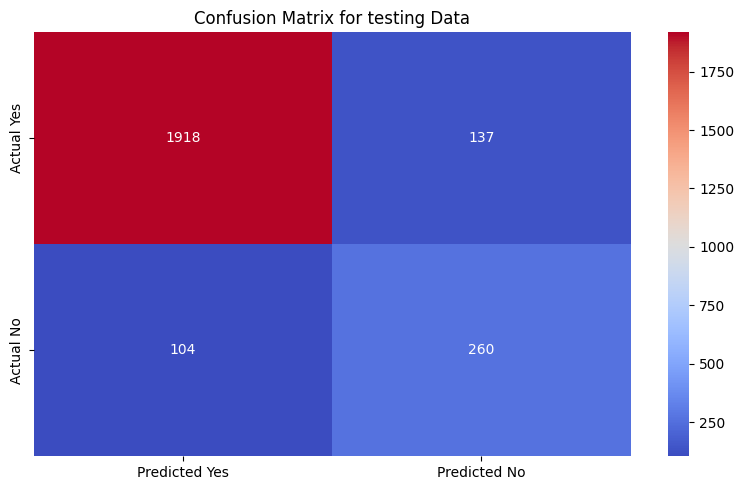

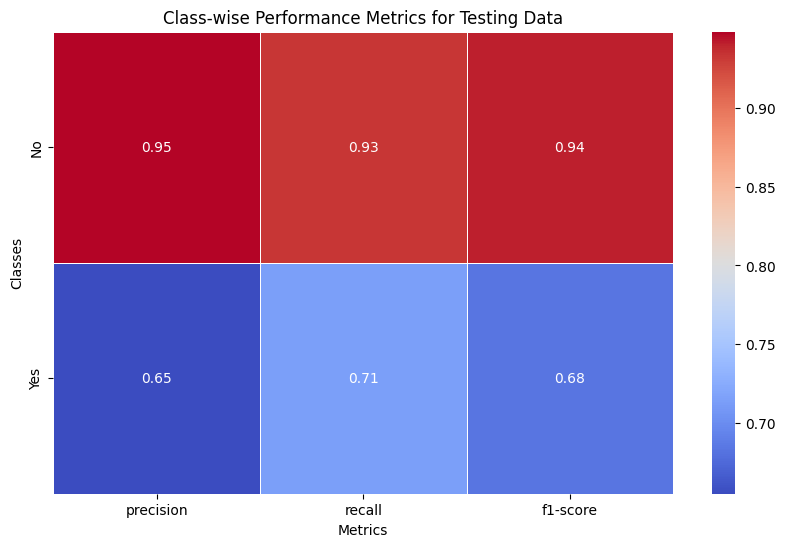

In [17]:
# Visualize the output of testing set

# Classification Report
testing_classification_report=classification_report(y_test, y_test_pred)
print("For testing data: ")
print(testing_classification_report)

# Confusion matrix with seaborn Heatmap
testing_conf_matrix=confusion_matrix(y_test, y_test_pred)
# Seaborn Heatmap
plt.figure(figsize=(8,5))
sns.heatmap(testing_conf_matrix, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted Yes', 'Predicted No'], yticklabels=['Actual Yes', 'Actual No'])
plt.title('Confusion Matrix for testing Data')
plt.tight_layout()
plt.savefig("testing_confusion_matrix.png")

# Visualize classification report better: Class-wise Performance Metrics
testing_classification_report_2 = classification_report(y_test, y_test_pred, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
class_metrics = {metric: [testing_classification_report_2[class_name][metric] for class_name in ['0','1']] for metric in metrics}

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data=pd.DataFrame(class_metrics, index=['No','Yes']), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Class-wise Performance Metrics for Testing Data')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.savefig("performance_metrics.png")
plt.show()

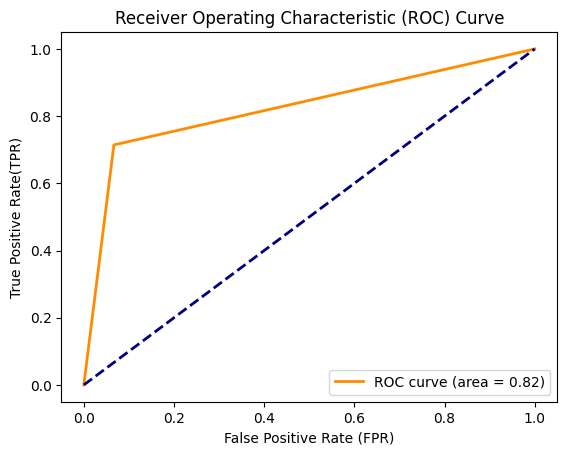

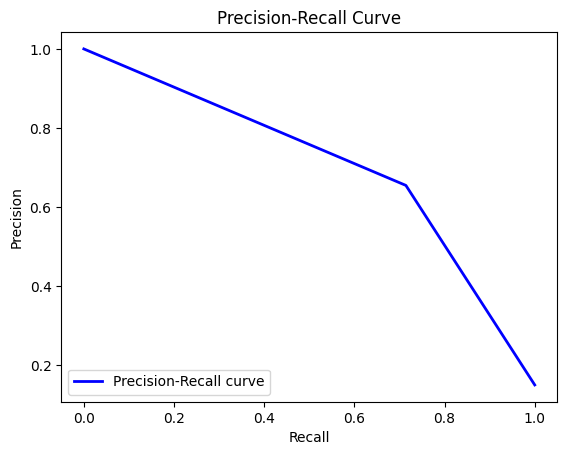

In [18]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig("precision_recall_curve.png")
plt.show()

In [19]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=9)


# feature_importance = pd.DataFrame({'Feature': X.columns,
#                                    'Importance': result.importances_mean,
#                                    'Standard Deviation': result.importances_std})
# feature_importance = feature_importance.sort_values('Importance', ascending=True)


# ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), yerr='Standard Deviation', capsize=4)
# ax.set_xlabel('Permutation Importance')
# ax.set_title('Permutation Importance with Standard Deviation')

In [20]:
# 1. All features
# model = LogisticRegression()
# model.fit(X_train, y_train)

# y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)


# print("Training set accuracy", accuracy_score(y_train_pred, y_train))
# print("Testing set accuracy", accuracy_score(y_test_pred, y_test))


# print("Balanced training set accuracy", balanced_accuracy_score(y_train_pred, y_train))
# print("Balanced testing set accuracy", accuracy_score(y_test_pred, y_test))

In [21]:
# # # load library
# from sklearn.svm import SVC

# estimator = SVC(class_weight='balanced', probability=True)
# cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=9)
# selector = RFECV(estimator, step=1, cv=cv)
# selector = selector.fit(X_train, y_train['Revenue'])

# RFECV_model = LogisticRegression()

# RFECV_model.fit(X_train[X_train.columns[selector.get_support()]], y_train['Revenue'])


# # we can add class_weight='balanced' to add panalize mistake
# svc_model = SVC(class_weight='balanced', probability=True)

# svc_model.fit(X_train, y_train['Revenue'])

# y_test_pred = svc_model.predict(X_test)# check performance
# print('ROCAUC score:',roc_auc_score(y_test, y_test_pred))
# print('Accuracy score:',accuracy_score(y_test, y_test_pred))
# print('F1 score:',f1_score(y_test, y_test_pred))